#STOCKS MODEL

Using Yahoo Finance stock data to predict if a stock will be a higher price next week.

A classification problem:
  given -> previous week of trading of a ticker, including today
  will the stock be higher at the close in 48 hours?


Argument for choosing low is that it guarantees you could sell on that day for more than the stock's value a week ago.

# Environment Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install necessary modules
#!pip install alpha_vantage

# Google finance API no longer available
# googlefinance provides stock price data
#!pip install googlefinance


!pip install get-all-tickers
!pip install yfinance

# tweepy is Twitter API wrapper
# !pip install tweepy

# skrebate contains ReliefF algo for feature selection
!pip install skrebate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for get-all-tickers: filename=get_all_tickers-1.8-py3-none-any.whl size=4248 sha256=86659acbbc71113d9cb761cd37ce756ef9e7ef7cdf26a1e6c31f529b4fa334e0
  Stored in directory: /root/.cache/pip/wheels/f0/8d/8f/25b9632788de8771fb8be22529bbe0ba5ae5446f3be65b1ab3
Successfully built get-all-tickers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 10.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all 

In [ ]:
# import necessary modules

# General use
import os
import io
import re
import datetime

import numpy as np
import matplotlib.pyplot as plt

# read_json(path_or_buf) -> DataFrame
# DataFrame.iloc[idx] -> DataFrame `sub-frame at given index`
import pandas as pd

# Data collection
import requests
import random

# why this here??
# import time

# googlefinance is a dead project
# Google API has updated since, returns 403 error

from get_all_tickers import get_tickers

# download(tickers(list or string), period, interval) -> pd.DataFrame
# ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] per ticker per interval
import yfinance

# Go to docs.tweepy.org for OAuth setup
# search_full_archive requires premium api subscription :(
# API.search_full_archive()
# max 100 matching tweets per page
# would have to iterate through each page to get total count
# API.search() -> SearchResults
# import tweepy


# Feature Selection

# __init__(self, n_features_to_select=10, n_neighbors=100, discrete_threshold=10, verbose=False, n_jobs=1)
# fit(self, X, y)
# transform(self, X) -> X_reduced (n_features_to_select, )
# fit_transform(self, X, y) = fit() && transform()
# self.feature_importances_ contains weights but might not be accessible
from skrebate import ReliefF



# __init__(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
# n_components can be 'mle', an algo to guess the appropriate dimensionality
# fit(self, X)
# transform(self, X) -> X_new
# fit_transform(self, X) = fit && transform
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split



# Classification

from keras.models import Sequential, Model
from keras import Input
from keras.layers import Conv1D, LSTM, Dense
from keras.layers import MaxPooling1D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint


# Hyperparameter Tuning

# a wrapper to allow sklearn to run *SearchCV on the keras model
# __init__(self, build_fn)
from keras.wrappers.scikit_learn import KerasClassifier

# Don't know if I want to do a grid search or random search yet
# guess it depends on the number of combinations i want to try

# __init__(estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, verbose=0)
# best_estimator -> estimator
# best_score -> float
# best_params -> dict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# Constants

os.chdir('/content/drive/MyDrive/stonks_model')

CURRENT_DIR = os.getcwd()
DATA_DIR = os.path.join(CURRENT_DIR, "data")

SYMBOLS = []


# Doing it this way will only get me data from current month,
# which might actually be a good thing?
# Real-time behavior is probably dependent on recent behavior,
# i.e. acceptable overfitting

INTERVAL = '30m'
D59 = datetime.timedelta(days=59)
D6 = datetime.timedelta(days=6)
PERIOD = '60d'


START_DATE = datetime.date.today() - D59
END_DATE = datetime.date.today()

INPUT_DAYS = 10
RESULT_DAYS = 2


START_STR = START_DATE.strftime('%Y-%m-%d')
END_STR = END_DATE.strftime('%Y-%m-%d')
print(START_STR, END_STR)


INPUT_NUM_INTERVALS = int(INPUT_DAYS*9.5*60/15)
RESULT_INTERVAL_BUFFER = int(RESULT_DAYS*9.5*60/15)

# roughly 50% of tickers from symbol source have NaNs
# so num_tickers should be x2 the desired number
NUM_TICKERS = 10

# class index 0 is predicting the stock will be higher 
# class index 1 is predicting the stock will be lower
CLASS_WEIGHT = {0: 50., 1: 1.}

# interpret yfinance interval input for period conversion
INTERVAL_DICT = {'1m': 1, '2m': 2, '5m': 5, '15m': 15, '30m': 30, '60m': 60, '90m': 90}
PRICE_LABELS = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

2022-04-08 2022-06-06


In [ ]:
print(START_DATE.weekday())

aapl = yfinance.Ticker("AAPL")
print(aapl.history(interval='30m', start=START_STR, end=END_STR).iloc[-1])

4
Open            146.139999
High            146.139999
Low             146.139999
Close           146.139999
Volume            0.000000
Dividends         0.000000
Stock Splits      0.000000
Name: 2022-06-06 16:00:00-04:00, dtype: float64


# Download input stock data

In [ ]:
def clean_data(data):
  drop = False
  dropcount = 0
  print("Starting with {} tickers".format(len(data.columns.unique(level=0))))
  for ticker in data.columns.unique(level=0):
    drop = False
    for price_label in data.columns.unique(level=1):
      for datapoint in data[ticker][price_label]:
        if np.isnan(datapoint):
          drop = True
          break
    if drop:
      dropcount += 1
      data.drop(columns=ticker, level=0, axis=1, inplace=True)
  print("{} tickers dropped for NaN values".format(dropcount))
  return data

def download_data(num_tickers):

  listings = pd.read_csv(os.path.join(DATA_DIR, 'symbols.csv'))
  symbols = listings['Symbol'].tolist()
  
  symbol_subset = random.sample(symbols, num_tickers)

  data = yfinance.download(symbol_subset, start=START_STR, end=END_STR, interval=INTERVAL, group_by='ticker')
  return clean_data(data)

# for testing functions
def download_ticker(symbol):
  return yfinance.download(symbol, start=START_STR, end=END_STR, interval=INTERVAL, group_by='ticker')

def download_prediction_tickers(symbols):
  data = yfinance.download(symbols, period=PERIOD, interval=INTERVAL, group_by='ticker')
  print(data)
  return data[-191:]

In [ ]:
print(download_data(100).shape)

[*********************100%***********************]  100 of 100 completed

17 Failed downloads:
- VACQU: No data found, symbol may be delisted
- CHKEZ: No data found for this date range, symbol may be delisted
- FLIR: No data found, symbol may be delisted
- SMTX: No data found, symbol may be delisted
- CMFNL: No data found, symbol may be delisted
- TDAC: No data found, symbol may be delisted
- BOKFL: No data found, symbol may be delisted
- BFT: No data found, symbol may be delisted
- BHTG: No data found, symbol may be delisted
- HMI: No data found, symbol may be delisted
- STND: No data found, symbol may be delisted
- JIH: No data found, symbol may be delisted
- HOFVW: No data found for this date range, symbol may be delisted
- CMD: No data found, symbol may be delisted
- CENHU: No data found, symbol may be delisted
- AJAX: No data found, symbol may be delisted
- SC: No data found, symbol may be delisted
Starting with 100 tickers
79 tickers dropped for NaN values
(508, 126)


# Define technical indicators

In [ ]:
# What indicators do I want in my dataset?

# for each func expecting pd.DataFrame
# with list of prices of form
# ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# what interval do we want
# what price point do we want? low, close?
# period is in intervals

# final
def SMA(data, period=10):
  sma = np.zeros(len(data))

  for i in range(period-1, len(data)):
      sma[i] = sum(data['Close'][i-period+1:i+1])/period

  return sma

# final
def EMA(data, period=8, smoothing=2):
  ema = np.zeros(len(data))

  ema[period-1] = np.average(data['Close'][:period])
  for i in range(period, len(data)):
    ema[i] = (data['Close'][i] - ema[i-1]) * smoothing/(1+period) + ema[i-1]

  return ema

# Range of 0 to 100
# final
def RSI(data, period=14):
  changes = np.zeros((len(data), 2))
  rsi = np.zeros(len(data))
  avg_up = 0
  avg_down = 0

  # First calculation
  # Use basic average for period gains and losses
  for i in range(1, period+1):
    change = data['Close'][i] - data['Close'][i-1]
    changes[i] = (0 if change == 0 else int(change/np.abs(change)), np.abs(change))
  ups = [change for (label, change) in changes[:period+1] if label == 1]
  downs = [change for (label, change) in changes[:period+1] if label == -1]
  if len(ups) == 0:
    avg_up = 0
    rsi[period] = 0
  elif len(downs) == 0:
    avg_down = 0
    rsi[period] = 100
  else:
    avg_up = np.average(ups)
    avg_down = np.average(downs)
    rsi[period] = 100 - 100 / (1 + avg_up/avg_down)

  # Following calculations
  # Use Wilder smoothing for average gains and losses
  for i in range(period+1, len(data)):
    change = data['Close'][i] - data['Close'][i-1]
    changes[i] = (0 if change == 0 else int(change/np.abs(change)), np.abs(change))

    if changes[i][0] == 1:
      avg_up = (avg_up*(period-1) + changes[i][1])/period
      avg_down = avg_down*(period-1)/period
    elif changes[i][0] == -1:
      avg_down = (avg_down*(period-1) + changes[i][1])/period
      avg_up = avg_up*(period-1)/period

    if avg_down == 0:
      rsi[i] = 100
    else:
      rsi[i] = 100 - (100/(1+(avg_up/avg_down)))
  return rsi

#final
def K_percent(data, period=5):
  k_percent = np.zeros(len(data))

  for i in range(period-1, len(data)):
    period_low = min(data['Low'][i-period+1:i+1])
    period_high = max(data['High'][i-period+1:i+1])
    if period_high == period_low :
      print('kp: div0 at phigh - plow')
    k_percent[i] = (data['Close'][i] - period_low)/(period_high - period_low) * 100

  return k_percent

# final
def VWAP(data):
  vwap = np.zeros(len(data))

  curr_date = ''
  pv = 0
  vol = 0
  for i in range(len(data)):
      typ_price = np.average([data['High'][i], data['Low'][i], data['Close'][i]])
      curr_vol = data['Volume'][i]

      # check if datapoint is on a new day -> VWAP resets
      date = re.search(r"\d{4}-\d{2}-\d{2}", str(data.iloc[i].name)).group(0)
      if not date == curr_date:
        curr_date = date
        pv = typ_price*curr_vol
        vol = curr_vol
      else:
        pv += typ_price*curr_vol
        vol += curr_vol

      if vol == 0:
        vwap[i] = 0
      else:
        vwap[i] = pv/vol

  return vwap

# final
# subtracts 26-period EMA from 12-period EMA
def MACD(data):
  macd = np.zeros(len(data))

  ema26 = EMA(data, period=26)
  ema12 = EMA(data, period=12)
  macd = np.array([ema26[i]-ema12[i] for i in range(len(data))])
  return macd

#final
def CCI(data, period=20):
  cci = np.zeros(len(data))

  ma = SMA(data, period)
  typ_prices = [np.average([data['High'][i], data['Low'][i], data['Close'][i]]) \
               for i in range(len(data))]

  for i in range(period-1, len(data)): 
    mean_dev = sum(np.abs(typ_prices[j] - ma[i]) for j in range(i-period+1, i+1) )/period
    cci[i] = (typ_prices[i] - ma[i]) / (0.015 * mean_dev)
    
  return cci

#final
def ATR(data, period=14):
  atr = np.zeros(len(data))
  tr = np.zeros(len(data))


  tr[0] = data['High'][0] - data['Low'][0]
  for i in range(1, len(data)):
    tr[i] = max( data['High'][i] - data["Low"][i],
             np.abs(data['High'][i] - data['Close'][i-1]),
             np.abs(data['Low'][i] - data['Close'][i-1]) )
  
    if i == period-1:
      atr[i] = np.average(tr[:period])
    elif i >= period:
      atr[i] = (atr[i-1]*(period-1) + tr[i]) / period

  return atr

#final
def ADX(data, period=14):

  dx = np.zeros(len(data))
  adx = np.zeros(len(data))
  pos_dm = np.zeros(len(data))
  neg_dm = np.zeros(len(data))
  smooth_pos_dm = np.zeros(len(data))
  smooth_neg_dm = np.zeros(len(data))

  atr = ATR(data, period)

  for i in range(1, len(data)):
    pos_dm[i] = data['High'][i] - data['High'][i-1]
    neg_dm[i] = data['Low'][i-1] - data['Low'][i]

    if pos_dm[i] < neg_dm[i] or pos_dm[i] < 0:
      pos_dm[i] = 0
    if neg_dm[i] < pos_dm[i] or neg_dm[i] < 0:
      neg_dm[i] = 0

    if i == period-1:
      smooth_pos_dm[i] = np.average(pos_dm[:period])
      smooth_neg_dm[i] = np.average(neg_dm[:period])

      pos_di = 100*smooth_pos_dm[i]/atr[i]
      neg_di = 100*smooth_neg_dm[i]/atr[i]

      dx[i] = 100 * np.abs(pos_di - neg_di)/np.abs(pos_di + neg_di)

      adx[i] = np.average(dx[:period])
    elif i >= period:
      smooth_pos_dm[i] = (smooth_pos_dm[i-1] * (period-1) + pos_dm[i])/period
      smooth_neg_dm[i] = (smooth_neg_dm[i-1] * (period-1) + neg_dm[i])/period

      pos_di = 100 * smooth_pos_dm[i]/atr[i]
      neg_di = 100 * smooth_neg_dm[i]/atr[i]

      dx[i] = 100 * np.abs(pos_di - neg_di)/np.abs(pos_di + neg_di)

      adx[i] = (adx[i-1]*(period-1) + dx[i])/period

  return adx

#final
def BBAND_UP(data, period=20, std_range=2):
  typ_prices = np.zeros(len(data))
  tp_std = np.zeros(len(data))

  typ_prices = [np.average([data['High'][i], data['Low'][i], data['Close'][i]]) \
               for i in range(len(data))]
  sma = SMA(data, period=period)
  tp_std = [np.std(typ_prices[i-period+1:i+1]) if i >= period-1 else 0 for i in range(len(data))]
  bolu = [ sma[i] + std_range * tp_std[i] for i in range(len(data)) ]
  return bolu

#final
def BBAND_DOWN(data, period=20, std_range=2):
  typ_prices = np.zeros(len(data))
  tp_std = np.zeros(len(data))

  typ_prices = [np.average([data['High'][i], data['Low'][i], data['Close'][i]]) \
               for i in range(len(data))]
  sma = SMA(data, period=period)
  tp_std = [np.std(typ_prices[i-period+1:i+1]) if i >= period-1 else 0 for i in range(len(data))]
  bold = [ sma[i] - std_range * tp_std[i] for i in range(len(data)) ]
  return bold

[*********************100%***********************]  1 of 1 completed


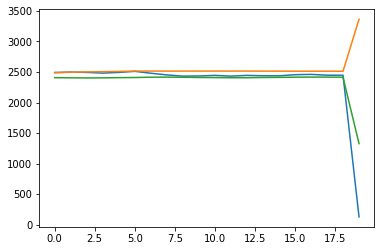

In [ ]:
# Test functions
amzn = download_ticker('AMZN')
bolu = BBAND_UP(amzn)[-20:]
bold = BBAND_DOWN(amzn)[-20:]
plt.plot(list(amzn['Close'][-20:]))
plt.plot(bolu)
plt.plot(bold)


plt.show()

# Build datasets

In [ ]:
# normalization functions

# sigmoid is cumulative distribution function for normally distributed data
# i.e. -inf to inf with 
def sigmoid(x):
  X = np.array(x)
  return 1 / (1 + np.exp(-X))

# exp_norm is cdf for exponentially distributed data
# i.e. 0 to inf with values closer to inf less likely
def exp_norm(x):
  X = np.array(x)
  return 1 - np.exp(-X/np.average(X))

def percent(x):
  X = np.array(x)
  return X / 100

In [ ]:
# Correlating function and normalization function for each indicator
TECH_INDICATORS = {'SMA': (SMA, exp_norm),
                  'EMA': (EMA, exp_norm),
                  'RSI': (RSI, percent),
                  'K_percent': (K_percent, percent),
                  'VWAP': (VWAP, exp_norm),
                  'MACD': (MACD, sigmoid),
                  'CCI': (CCI, sigmoid),
                  'ATR': (ATR, exp_norm),
                  'ADX': (ADX, percent),
                  'BBAND_UP': (BBAND_UP, exp_norm),
                  'BBAND_DOWN': (BBAND_DOWN, exp_norm)}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


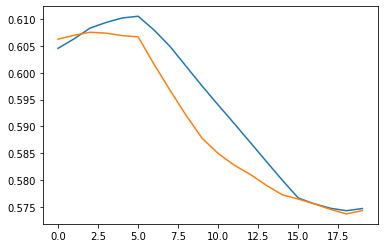

In [ ]:
# Test normalization

sma = exp_norm(SMA(download_ticker('TSLA')))[-20:]
ema = exp_norm(EMA(download_ticker('TSLA')))[-20:]
plt.plot(sma)
plt.plot(ema)
plt.show()

In [ ]:
def normalize_dataset(data):
  norm_data_index = data.index.values
  norm_data_columns = pd.MultiIndex.from_product([data.columns.unique(level=0), \
                                                PRICE_LABELS + list(TECH_INDICATORS.keys())])
  norm_data = pd.DataFrame(index=norm_data_index, columns=norm_data_columns)

  print('normalizing data', data)
  for ticker in data.columns.unique(level=0):

    print("Building data for", ticker)

    # Normalize prices
    for price_label in PRICE_LABELS:
      #print(price_label)
      norm_price = exp_norm(data[ticker][price_label])
      #norm_data.insert(loc=len(norm_data.columns), column=(ticker, price_label), value=norm_price)
      norm_data[ticker, price_label] = norm_price

    # Add technical indicators
    for indicator_name in TECH_INDICATORS.keys():
      #print(indicator_name)
      ind_func = TECH_INDICATORS[indicator_name][0]
      func_norm = TECH_INDICATORS[indicator_name][1]
      #norm_data.insert(loc=len(norm_data.columns), column=(ticker, indicator_name), value=func_norm(ind_func(data[ticker])))
      norm_data[ticker, indicator_name] = func_norm(ind_func(data[ticker]))

  return norm_data


# split each ticker history into X = (F MTWTF MTWT), _=F MT ,y = W
# if a day is missing, fill with all price vals = previous day open

# first friday needs to be at least 2 days after start of dataset
# for technical indicators to develop

# do i need a buffer for the last wednesday
# since yfinance seems to do iffy things with the current day values

# data instances will overlap:
# data: F MTWTF MTWTF MTWTF MTWTF MTW
# i=0 : ______X_____    y
# i=1 :       ______X_____    y
# i=2 :             ______X_____    y
#def split_dataset(data):

def build_dataset(data):
  norm_data = normalize_dataset(data)
  X = np.array([norm_data[ticker][i-INPUT_NUM_INTERVALS:i+1] \
       for ticker in norm_data.columns.unique(level=0) \
       for i in range(INPUT_NUM_INTERVALS, len(norm_data[ticker].index) - RESULT_INTERVAL_BUFFER)])
  y = np.array([[1,0] if norm_data[ticker]['Close'][i] >= 1.0*norm_data[ticker]['Close'][i-RESULT_INTERVAL_BUFFER] else [0,1] \
       for ticker in norm_data.columns.unique(level=0) \
       for i in range(INPUT_NUM_INTERVALS + RESULT_INTERVAL_BUFFER, len(norm_data[ticker].index))])
  
  
  return X, y
# For prediction data we need latest sequence of F MTWTF MTWT
# assuming we are running this on a thursday evening to make buys on following friday
# get latest thurdsay to 2nd friday before that date
def build_prediction_data(data):
  norm_data = normalize_dataset(data)
  X = np.array([norm_data[ticker] \
       for ticker in norm_data.columns.unique(level=0)])
  return X

In [ ]:
# 100 might be the max number of tickers we can download at once
X, y = build_dataset(download_data(90))

[*********************100%***********************]  90 of 90 completed

10 Failed downloads:
- BSA: No data found, symbol may be delisted
- LOAC: No data found, symbol may be delisted
- SPKE: No data found, symbol may be delisted
- CFX: No data found for this date range, symbol may be delisted
- HCARW: No data found for this date range, symbol may be delisted
- CCX: No data found, symbol may be delisted
- RIVE: No data found, symbol may be delisted
- STWOU: No data found for this date range, symbol may be delisted
- FLXN: No data found, symbol may be delisted
- CREE: No data found, symbol may be delisted
Starting with 90 tickers
50 tickers dropped for NaN values
normalizing data                             MGNX                                        \
                            Open  High    Low  Close Adj Close  Volume   
Datetime                                                                 
2022-04-08 09:30:00-04:00  9.460  9.46  9.040  9.040     9.040   21368   
2022-04-08 10:00

In [ ]:
print(X.shape)
print(y.shape)
print(X)

(2080, 381, 17)
(2080, 2)
[[[0.80362656 0.80086758 0.79219231 ... 0.         0.         0.        ]
  [0.78890979 0.78897623 0.79001395 ... 0.         0.         0.        ]
  [0.79143702 0.78969499 0.79219231 ... 0.         0.         0.        ]
  ...
  [0.50697142 0.5069266  0.49797868 ... 0.30189124 0.49553981 0.51199646]
  [0.49581885 0.49457804 0.49315689 ... 0.2870996  0.49572732 0.51188806]
  [0.48970949 0.48855008 0.49050733 ... 0.26926082 0.49561023 0.51192111]]

 [[0.78890979 0.78897623 0.79001395 ... 0.         0.         0.        ]
  [0.79143702 0.78969499 0.79219231 ... 0.         0.         0.        ]
  [0.79107788 0.79041127 0.79363197 ... 0.         0.         0.        ]
  ...
  [0.49581885 0.49457804 0.49315689 ... 0.2870996  0.49572732 0.51188806]
  [0.48970949 0.48855008 0.49050733 ... 0.26926082 0.49561023 0.51192111]
  [0.4888307  0.48719593 0.48917735 ... 0.25066002 0.49574014 0.51215106]]

 [[0.79143702 0.78969499 0.79219231 ... 0.         0.         0.      

# Build feature selection algorithm

In [ ]:
# We have 17 features: 6 price features and 11 technical indicators at the moment

# ReliefF might not be a good choice with only 17 features to analyze
# not worth the runtime

# PCA might still be useful though
# would have to write a custom 

# relieff and pca expect 2d arrays: (num_samples, num_features)
# so we remove the time series aspect of our training data
# idk if this will work though
def select_features(X, y, num_iter=10):
  # Run this algo on a random selection of samples and average? the results
  # this strategy works on PCA bu
  #relieff_selector = ReliefF(n_features_to_select=15, n_neighbors=100, verbose=True, n_jobs=1)
  pca = PCA(n_components='mle', svd_solver='auto')
  for i in random.choices(range(len(X)), k=num_iter):
    #relieff_selector.fit(X[i], y[i])
    #scores = relieff_selector.feature_importances_
    #print(scores)
    X_reduced = pca.fit_transform(X[i])
    print(pca.explained_variance_)

In [ ]:
select_features(X, y)

[2.77351145e-01 7.36048816e-02 3.62045342e-02 1.61875254e-02
 7.84498611e-03 5.17116546e-03 1.50214815e-03 5.05225069e-04
 3.17308816e-05 1.65280767e-05 1.02306551e-05 5.20734428e-06
 3.43985248e-06 3.12968318e-06 1.44639472e-06 3.05053673e-07]
[2.92913090e-01 7.04623187e-02 4.37567394e-02 2.77472353e-02
 1.15979254e-02 5.19210190e-03 3.00593173e-03 1.31592622e-03
 7.72948731e-04 2.55667047e-05 6.28143389e-06 3.12208571e-06
 2.31990587e-06 1.60730260e-06 4.98845103e-07 1.64456628e-07]
[2.38309781e-01 1.10171808e-01 7.00951567e-02 2.50398997e-02
 1.16934114e-02 3.25080665e-03 1.78975939e-03 2.12605372e-04
 1.45755273e-04 7.31506209e-05 2.55483361e-05 1.34338289e-05
 8.85196833e-06 6.65178362e-06 2.00273531e-06 9.38354201e-07]
[2.75654876e-01 7.00018175e-02 6.14738871e-02 1.78586177e-02
 7.29599617e-03 3.67611308e-03 2.67116564e-03 9.77785614e-05
 5.04726467e-05 2.04786051e-05 8.55629633e-06 5.89178981e-06
 4.69220208e-06 3.47226643e-06 1.04357914e-06 3.30783250e-07]
[3.06697028e-01 7.58

# Build classifier

In [ ]:
def build_model(conv_filters=32, conv_kernel_size=2, lstm_units=5, dropout_rate=0.01):
  model = Sequential()
  model.add(Conv1D(filters=conv_filters, kernel_size=conv_kernel_size, input_shape=(INPUT_NUM_INTERVALS+1, 17), activation='relu'))
  model.add(Dropout(rate=dropout_rate))
  model.add(LSTM(units=lstm_units))
  model.add(Dropout(rate=dropout_rate))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return model

# Perform hyperparameter tuning

In [ ]:
def tune_hyperparameters(params, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  model = KerasClassifier(build_fn=build_model)
  random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, n_jobs=4, verbose=1)
  random_search.fit(X_train, y_train, validation_data=(X_test, y_test), class_weight=CLASS_WEIGHT, batch_size=10, epochs=2, verbose=1)
  print("Best params:")
  print(random_search.best_params_)
  return random_search.best_estimator_ #, random_seach.best_score

In [ ]:
params = {
      'conv_filters': [16, 32, 64],
      'conv_kernel_size': [1, 2, 4],
      'lstm_units': [3, 5, 8],
      'dropout_rate': [0.01, 0.1, 0.2]
}

best_model = tune_hyperparameters(params, X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 55.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 63.2min finished


Epoch 1/2
794/794 [==============================] - 51s 62ms/step - loss: 3.7878 - accuracy: 0.5783 - val_loss: 1.6954 - val_accuracy: 0.5955
Epoch 2/2
794/794 [==============================] - 49s 61ms/step - loss: 2.2342 - accuracy: 0.5747 - val_loss: 1.7063 - val_accuracy: 0.5955
Best params:
{'lstm_units': 8, 'dropout_rate': 0.01, 'conv_kernel_size': 2, 'conv_filters': 64}


In [ ]:
best_model.summary()

AttributeError: ignored

 # Train

In [ ]:
def train_model(model, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=100, verbose=1)#, class_weight=CLASS_WEIGHT)
  return history

In [ ]:
model = build_model()
history = train_model(model, X, y)

Epoch 1/100
156/156 [==============================] - 18s 102ms/step - loss: 0.4886 - accuracy: 0.8577 - val_loss: 0.3855 - val_accuracy: 0.8904
Epoch 2/100
156/156 [==============================] - 15s 97ms/step - loss: 0.4077 - accuracy: 0.8583 - val_loss: 0.3474 - val_accuracy: 0.8904
Epoch 3/100
156/156 [==============================] - 15s 95ms/step - loss: 0.4055 - accuracy: 0.8583 - val_loss: 0.3716 - val_accuracy: 0.8904
Epoch 4/100
156/156 [==============================] - 15s 94ms/step - loss: 0.4048 - accuracy: 0.8583 - val_loss: 0.3475 - val_accuracy: 0.8904
Epoch 5/100
156/156 [==============================] - 15s 97ms/step - loss: 0.4021 - accuracy: 0.8583 - val_loss: 0.3415 - val_accuracy: 0.8904
Epoch 6/100
156/156 [==============================] - 17s 108ms/step - loss: 0.4008 - accuracy: 0.8583 - val_loss: 0.3395 - val_accuracy: 0.8904
Epoch 7/100
156/156 [==============================] - 14s 92ms/step - loss: 0.4005 - accuracy: 0.8583 - val_loss: 0.3375 - val_

# Evaluate

In [ ]:
def test_model(model, history):
  X_test, y_test = build_dataset(download_data(10))
  scores = model.evaluate(X_test, y_test)
  
for name, val in zip(model.metrics_names, scores):
  print(name,":",val)

  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.plot(history.history['val_loss'], label='Validation Loss')

  plt.legend()
  plt.show()

In [ ]:
test_model(model)

2967
[*********************100%***********************]  10 of 10 completed

6 Failed downloads:
- DWCH: No data found for this date range, symbol may be delisted
- NRX: No data found for this date range, symbol may be delisted
- ARRS: No data found, symbol may be delisted
- VIAB: No data found, symbol may be delisted
- STB: No data found, symbol may be delisted
- BSTC: No data found, symbol may be delisted
Dropping DWCH
Dropping NRX
Dropping ARRS
Dropping VIAB
Dropping STB
Dropping BSTC
Dropping MOSY
(821, 18)
normalizing data                               SBLK           ...       LBRDK        
                              Open     High  ...   Adj Close  Volume
2020-12-16 09:30:00-05:00   7.8000   7.8500  ...  160.350006   26455
2020-12-16 09:45:00-05:00   7.7150   7.7446  ...  161.229996   88104
2020-12-16 10:00:00-05:00   7.6900   7.6900  ...  160.910004   32147
2020-12-16 10:15:00-05:00   7.6400   7.6900  ...  161.169998   58514
2020-12-16 10:30:00-05:00   7.6600   7.7500  ...  16

# Predict

In [ ]:
def predict(model, X):
  return model.predict(X)

In [ ]:
gme = build_prediction_data(download_prediction_ticker('GME AAPL AMZN'))
predict(model, gme)

[*********************100%***********************]  3 of 3 completed
                                  AMZN               ...         GME          
                                  Open         High  ...   Adj Close    Volume
Datetime                                             ...                      
2021-01-27 09:30:00-05:00  3341.489990  3346.520020  ...  312.000000  19569054
2021-01-27 09:45:00-05:00  3255.000000  3288.590088  ...  310.690002   4808932
2021-01-27 10:00:00-05:00  3287.376709  3306.870117  ...  249.720001   3435701
2021-01-27 10:15:00-05:00  3289.639893  3311.050049  ...  278.848511   3101187
2021-01-27 10:30:00-05:00  3297.429932  3304.272217  ...  307.000092   3745114
...                                ...          ...  ...         ...       ...
2021-02-02 14:45:00-05:00  3415.530029  3419.764893  ...   99.900002   1127809
2021-02-02 15:00:00-05:00  3416.979980  3416.979980  ...   98.500099   1038749
2021-02-02 15:15:00-05:00  3397.000000  3404.399902  ...   95.

array([[9.99884725e-01, 1.15317060e-04],
       [9.99889135e-01, 1.10888926e-04],
       [9.99887943e-01, 1.12064175e-04]], dtype=float32)

# Cleanup

In [ ]:
# remove all files from data dir
!rm /content/drive/MyDrive/stonks_model/data/*